<a href="https://colab.research.google.com/github/nedokormysh/GB_Libraries_python_for_DS/blob/CourseProject/Libraries_python_DS_CourseWork_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение библиотек

In [1]:
# Основные библиотеки
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Метрика качества
from sklearn.metrics import r2_score as r2

from scipy.stats import mode

# Разделение датасета
from sklearn.model_selection import train_test_split, cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Оптимизация данных

In [5]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

# **Загрузка, предобработка данных**

## Функция подсчёта метрик

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Загрузка данных

In [7]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Libraries_python_DS_CourseWork/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Libraries_python_DS_CourseWork/test.csv'
SAMPLE_DATASET_PATH = '/content/drive/MyDrive/Libraries_python_DS_CourseWork/sample_submission.csv'

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [9]:
print(f'В обучающем датафрейме {df_train.shape[0]} строк и {df_train.shape[1]} столбцов')

В обучающем датафрейме 10000 строк и 20 столбцов


In [10]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [11]:
print(f'В тестовом датафрейме {df_test.shape[0]} строк и {df_test.shape[1]} столбцов')

В тестовом датафрейме 5000 строк и 19 столбцов


### Разница в количестве признаков между train и test

Таким образом выполняется:

In [12]:
df_train.shape[1] - 1 == df_test.shape[1]

True

## Признаки нашего датасета

In [13]:
# print('Названия столбцов в обучающем датафрейме\n',df_train.columns)
nl = '\n'
print(f"Названия столбцов в обучающем датафрейме {nl}{df_train.columns}")

Названия столбцов в обучающем датафрейме 
Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

Задача регрессии на прогнозирование стоимости домов. Метрикой является коэффициент корреляции R2.

Наблюдения - это строки. Признаки - столбцы.

In [ ]:
# df_train.index

In [ ]:
# df_train.dtypes

## Уменьшение объема памяти, который занимает датасет

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [15]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [16]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


##Приведение типов.

In [17]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [18]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train['Ecology_2'] = df_train['Ecology_2'].astype(str)
df_train['Ecology_3'] = df_train['Ecology_3'].astype(str)
df_train['Shops_2'] = df_train['Shops_2'].astype(str)

In [19]:
df_train.dtypes

Id                object
DistrictId        object
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
Shops_2           object
Price            float32
dtype: object

In [20]:
num_feat = list(df_train.select_dtypes(exclude='object').columns)
# obj_feat = list(df_train.select_dtypes(include=('object', 'category')).columns)
nom_feat = list(df_train.select_dtypes(include='object').columns)
target = 'Price'

print(f'Числовые признаки: {num_feat}')
# print(f'Нечисловые признаки: {obj_feat}')
print(f'Номинативные признаки: {nom_feat}')

Числовые признаки: ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']
Номинативные признаки: ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']


# **EDA и очистка данных**

## Удаление дубликатов

In [21]:
df_train.shape

(10000, 20)

In [22]:
df_train = df_train.drop_duplicates()
df_train.shape

(10000, 20)

Дубликатов нет.

## Распределение целевой переменной

In [ ]:
# round(df_train['Price'].mean(), 2)
# round(df_train.Price.median(), 2)
# round(df_train.Price.mode()[0], 2)

In [ ]:
# mode(df_train.Price)[0][0]

In [ ]:
# df_train.Price.head()

In [23]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = round(df_train.Price.median(), 2)
# target_mode = df_train['Price'].mode()[0]
# target_mode = round(df_train['Price']).mode()[0]
target_mode = round(df_train.Price, -1).mode()[0]

In [24]:
print(f'Среднее значение целевой переменной = {target_mean}')
print(f'Медиана целевой переменной = {target_median}')
print(f'Мода целевого значения = {target_mode}')

Среднее значение целевой переменной = 214138.94
Медиана целевой переменной = 192269.66
Мода целевого значения = 181630.0


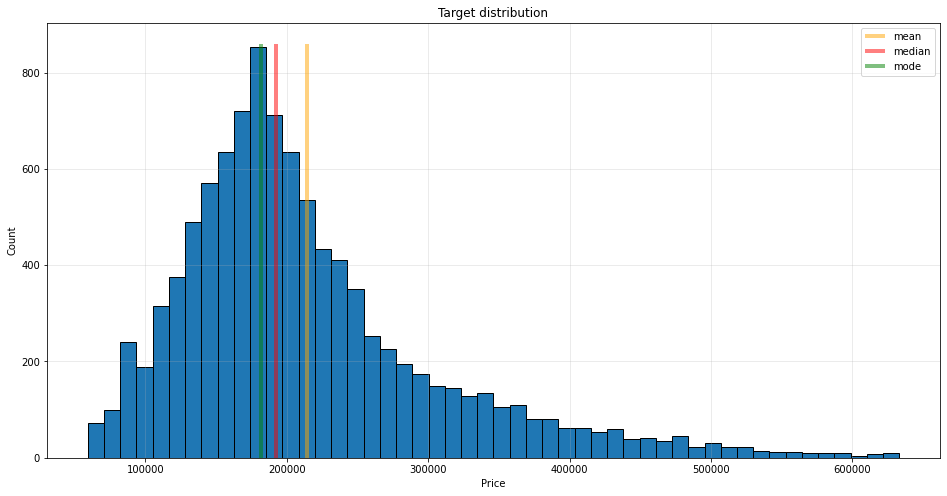

In [25]:
plt.figure(figsize = (16, 8))

y = df_train['Price']
plt.hist(y, bins=50, edgecolor='black')
# df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

# plt.plot([target_mean] * 85, y, label='mean',  linewidth=4)
# plt.plot([target_median] * 10, y, label='median',  linewidth=4)
# plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.vlines(target_mean, 0, 860, label='mean', linewidth=4, colors='orange', alpha=0.5)
plt.vlines(target_median, 0, 860, label='median', linewidth=4, colors='red', alpha=0.5)
plt.vlines(target_mode, 0, 860, label='mode', linewidth=4, colors='green', alpha=0.5)

plt.title('Target distribution')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Первоначально выбросов в целевой переменной нет. Несимметричное распределение.

In [ ]:
# plt.figure(figsize = (16, 8))

# sns.distplot(df_train['Price'], bins=30)

# y = np.linspace(0, 0.000005, 10)
# plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
# plt.plot([target_median] * 10, y, label='median',  linewidth=4)
# plt.plot([target_mode] * 10, y, label='mode', linewidth=4)
# # print(y.shape)

# plt.title('Distribution of median_house_value')
# plt.legend()
# plt.show()

## Количественные признаки

In [26]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## Корреляция

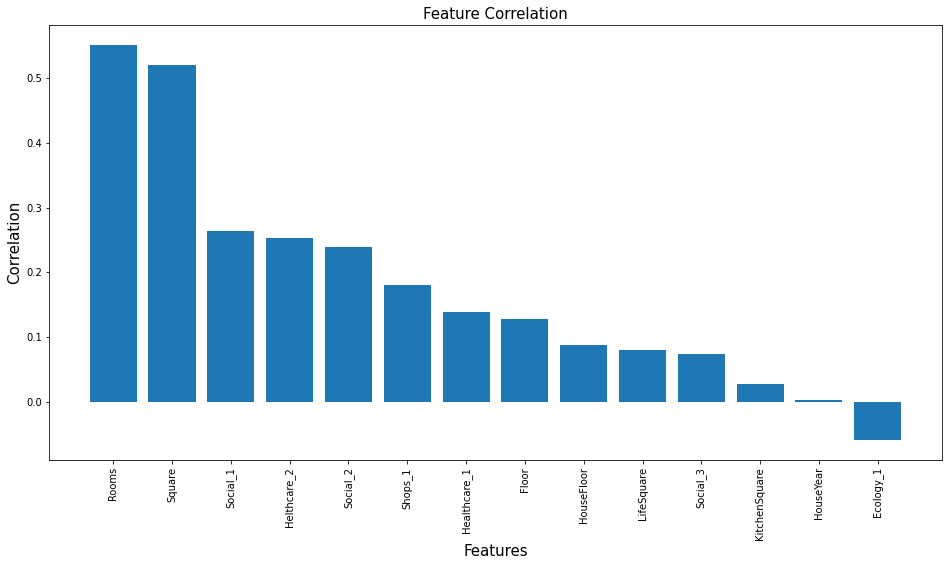

In [27]:
# Prepare Data
correlation = df_train.corrwith(df_train['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

# Draw plot
plt.figure(figsize = (16,8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')

# Decorations    
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature Correlation', fontsize=15)
plt.show()

Максимальная корреляция у нас отображается в зависимости от количества комнат и площади.

Text(0.5, 1.0, 'Correlation matrix')

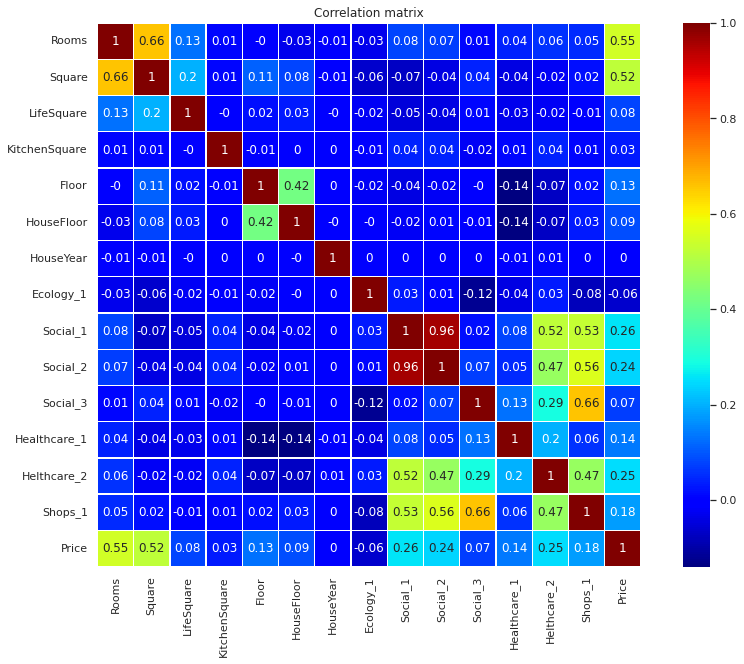

In [28]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
# corr_matrix[np.abs(corr_matrix) < 0.3] = 0


# corrmat = df_train.loc[:, df_train.columns != 'Id'].corr()
# plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=1, square=True)

sns.heatmap(corr_matrix, square=True, annot=True, linewidths=0.4, cmap='jet')

plt.title('Correlation matrix')

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r',

На хитмап также можно наблюдать, что максимальная корреляция у нас наблюдается в зависимости от площади и количества комнат (эти признаки коррелируют между собой.)

Также стоит отметить слабую зависимость от Ecology_1 и House_Year.

Забегая вперёд можем отметить Healthcare_1 также имеет слабую взаимосвязь c таргетом и остальными фичами.

In [29]:
# df_train = df_train.drop(['LifeSquare'], axis = 1)

## Номинативные признаки

In [30]:
nom_feat

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [31]:
def nom_feat_value_counts(nom_feat):
  for el in range(1, len(nom_feat)):
    # print(df_train[el].value_counts())
    # print(f'Уникальные значения номинативного признака {nom_feat[el]}:{nl * 2}{df_train[nom_feat[el]].value_counts()}{nl}')
    # print('\033[1m' + 'Eyb')
    print('\033[1m' + f'Уникальные значения номинативного признака {nom_feat[el]}:{nl * 2}'
     + '\033[0m' + f'{df_train[nom_feat[el]].value_counts()}{nl}')
    print('-' * 60)

In [32]:
nom_feat_value_counts(nom_feat)

Уникальные значения номинативного признака DistrictId:

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
209      1
199      1
205      1
196      1
Name: DistrictId, Length: 205, dtype: int64

------------------------------------------------------------
Уникальные значения номинативного признака Ecology_2:

B    9903
A      97
Name: Ecology_2, dtype: int64

------------------------------------------------------------
Уникальные значения номинативного признака Ecology_3:

B    9725
A     275
Name: Ecology_3, dtype: int64

------------------------------------------------------------
Уникальные значения номинативного признака Shops_2:

B    9175
A     825
Name: Shops_2, dtype: int64

------------------------------------------------------------


In [ ]:
# df_train['DistrictId'].value_counts()

In [ ]:
# df_train['Ecology_2'].value_counts()

In [ ]:
# df_train['Ecology_3'].value_counts()

In [ ]:
# df_train['Shops_2'].value_counts()

## Обработка выбросов

In [33]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


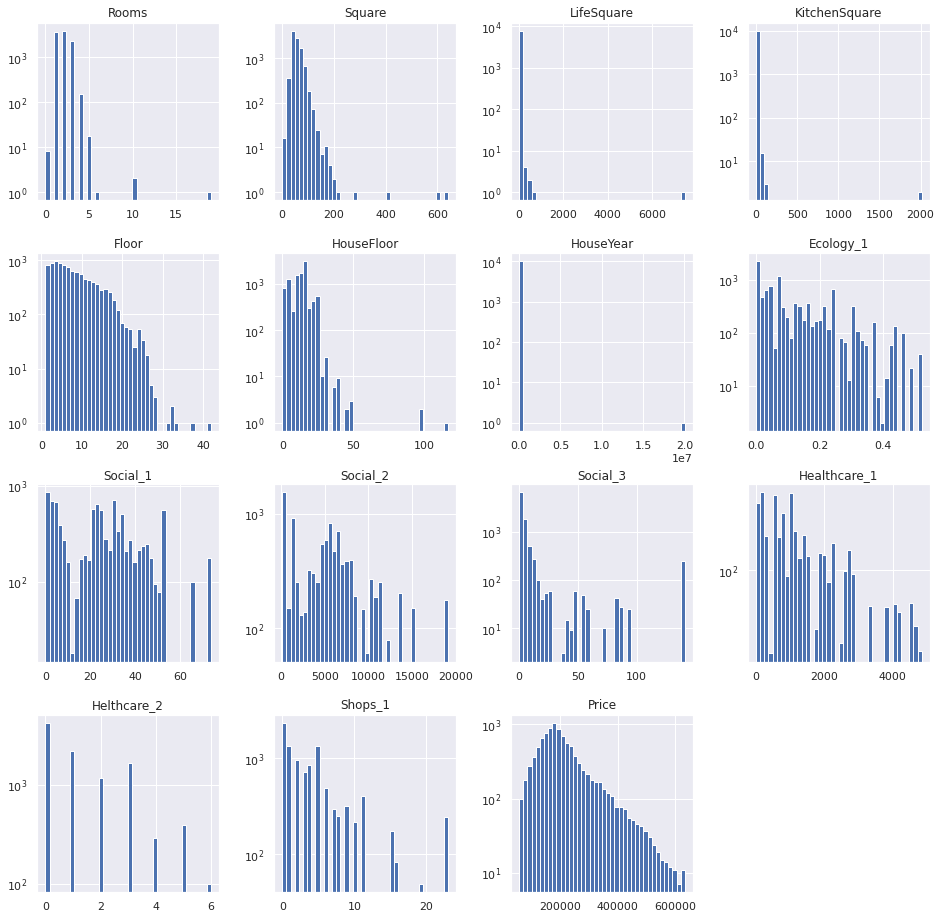

In [34]:
df_train[num_feat].hist(bins=40, figsize=(16, 16), log = True)

plt.show()

Нерациональные выбросы HouseYear, KitchenSquare и признаки с необоснованно выскоими значениями наблюдаются HouseFloor, LifeSquare, Rooms, Square

In [ ]:
# df_train.query('Rooms > 5')

https://leftjoin.ru/all/outliers-detection-in-python/

Рассмотрим данные подробнее

### HouseYear

In [35]:
# df_train['HouseYear'].hist(figsize=(4, 4), log=True)
# plt.title('HouseYear')
# plt.xlabel('year')

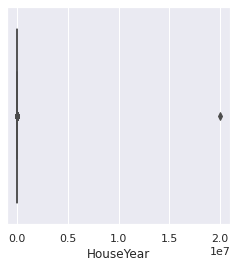

In [36]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_train['HouseYear'], whis=1.5, orient='h')

In [37]:
df_train.corr()['Price']['HouseYear']

0.00430539418333514

Т.е. у нас есть выбросы в этой фиче.

In [ ]:
# df_train.boxplot(column='HouseYear', rot=90)

In [38]:
df_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [39]:
df_train.loc[df_train['HouseYear'] > 2020, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375
9163,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250


Предположим, что значение 20052011 - это ошибка. Заменим 20052011 на 2011 предполагая, что 20052011 - это годы строительства.

Также заменим значение 4968 на 1968.

In [40]:
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2011
df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [41]:
df_filter = df_train['Id'].isin([10814, 11607])
df_train[df_filter]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [42]:
df_train.corr()['Price']['HouseYear']

0.036633776605036146

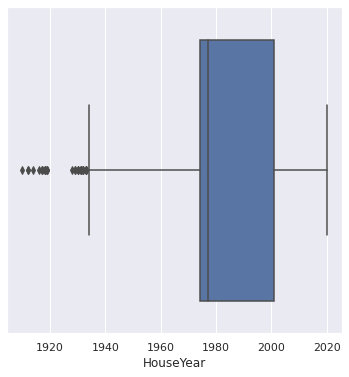

In [43]:
plt.figure(figsize=(6, 6))
sns.boxplot(df_train['HouseYear'], whis=1.5, orient='h')

### KitchenSquare

In [ ]:
# df_train['KitchenSquare'].hist(figsize=(4, 4), log=True)
# plt.title('KitchenSquare')
# plt.xlabel('Square')

In [44]:
df_train.corr()['Price']['KitchenSquare']

0.028864154932784696

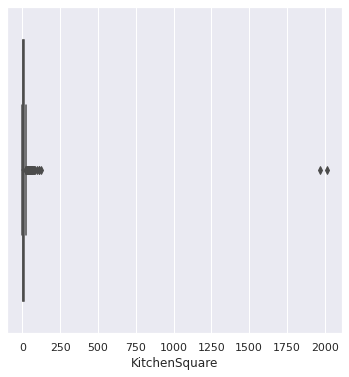

In [45]:
plt.figure(figsize=(6, 6))
sns.boxplot(df_train['KitchenSquare'], whis=1.5, orient='h')

In [46]:
(df_train['KitchenSquare'] > 1750).sum()

2

In [47]:
df_train[df_train['KitchenSquare'] > 1750]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6505,14679,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375


In [48]:
df_train[df_train.KitchenSquare > df_train.Square]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2785,6569,27,1.0,38.220257,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938
5273,13703,42,1.0,38.071693,19.723547,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250
6505,14679,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375


У нас есть два значения площади кухни, которые сильно отличаются от средних. Также у нас есть значения площади кухни, которые превышают значение общей площади квартиры. Заменим эти значения на значение медианы.

In [49]:
query_kitchen_square = df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975)
        
df_train.loc[query_kitchen_square, 'KitchenSquare'] = df_train['KitchenSquare'].median()

In [50]:
df_train.corr()['Price']['KitchenSquare']

0.28788778283654626

In [ ]:
# df_train['KitchenSquare'].value_counts()

Осталась проблема с минимальным размером кухни. Заменим все кухни с площадью меньше 3 на 3.

In [51]:
df_train.loc[df_train['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [52]:
df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

Square           0.520075
LifeSquare       0.081292
KitchenSquare    0.298118
Name: Price, dtype: float64

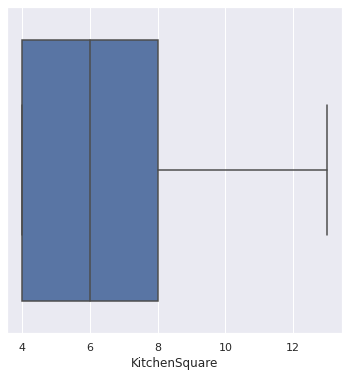

In [53]:
plt.figure(figsize=(6, 6))
sns.boxplot(df_train['KitchenSquare'], whis=1.5, orient='h')

In [ ]:
# df_train['KitchenSquare'].value_counts()

### Square

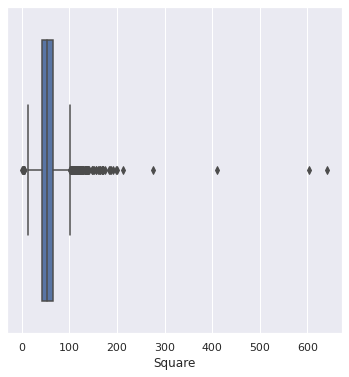

In [ ]:
plt.figure(figsize=(6, 6))
sns.boxplot(df_train['Square'], whis=1.5, orient='h')

In [ ]:
df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

Square           0.520075
LifeSquare       0.081292
KitchenSquare    0.028864
Name: Price, dtype: float64

In [ ]:
df_train[df_train['Square'] > 300]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
9229,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562


In [ ]:
query_square = df_train['Square'] > 300
        #  df_train['Square'].quantile(.975)
df_train.loc[query_square, 'Square'] = df_train['Square'].median()

In [ ]:
df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

Square           0.577892
LifeSquare       0.081292
KitchenSquare    0.028864
Name: Price, dtype: float64

In [ ]:
df_train['SquareKitchenSquare'] = df_train['Square'] - df_train['KitchenSquare']
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareKitchenSquare
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,105.027311
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,31.832524
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,68.342215
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,39.409907
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,55.285067


In [ ]:
# df_train[(df_train['LifeKitchenSquare']) > df_train['Square']]

In [ ]:
# df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['SquareKitchenSquare']

In [ ]:
# df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train['SquareKitchenSquare']
# df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train['SquareKitchenSquare'].median()

# square_index = df_train[df_train['LifeSquare'] > df_train['Square']].index
# df_train.loc[square_index, 'Square'], df_train.loc[square_index, 'LifeSquare'] = df_train.loc[square_index, 'LifeSquare'], df_train.loc[square_index, 'Square']

df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train['LifeSquare'].median()

In [ ]:
df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

Square           0.577892
LifeSquare       0.435550
KitchenSquare    0.028864
Name: Price, dtype: float64

In [ ]:
# df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['SquareKitchenSquare']
# df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['SquareKitchenSquare'].median()
df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = df_train['LifeSquare'].median()

In [ ]:
df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

Square           0.577892
LifeSquare       0.404126
KitchenSquare    0.028864
Name: Price, dtype: float64

In [ ]:
df_train.LifeKitchenSquare.isnull().sum()

0

In [ ]:
# df_train[(df_train['LifeSquare']) > df_train['Square']]

In [ ]:
# df_train.loc[df_train['Square'] < df_train['LifeSquare'], 'LifeSquare'] = (df_train['Square'] - df_train['KitchenSquare'])

In [ ]:
# df_train.loc[df_train['LifeSquare'].isnull(), 'LifeSquare'] = (df_train['Square'] - df_train['KitchenSquare'])

In [ ]:
# df_train[(df_train['LifeSquare']) == df_train['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeKitchenSquare
24,4717,27,1.0,44.203947,44.203947,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,44.203947
33,847,74,2.0,73.314975,73.314975,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863,75.131261
38,7679,23,2.0,55.521797,55.521797,0.0,3,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,93217.752924,55.521797
64,3992,1,3.0,87.200625,87.200625,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669,87.730225
77,11771,45,1.0,38.467276,38.467276,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601,40.624493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,14175,14,1.0,42.029175,42.029175,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617,54.682167
9979,2201,6,1.0,40.043234,40.043234,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598,42.984322
9987,11665,1,2.0,62.690057,62.690057,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698,74.602939
9991,11173,6,2.0,62.648779,62.648779,0.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.548872,62.648779


In [ ]:
# df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare', 'LifeKitchenSquare']]

Square               0.577892
LifeSquare           0.304173
KitchenSquare        0.028864
LifeKitchenSquare    0.084740
Name: Price, dtype: float64

In [ ]:
# query_life_square = df_train['LifeSquare'] > df_train['Square']

In [ ]:
# df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

KeyError: ignored

In [ ]:
# df_train['Square_tuned'] = df_train['LifeSquare'] + df_train['KitchenSquare']
# df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_tuned
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,NaN
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,31.169223
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,57.671972
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,NaN
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,47.562517


In [ ]:
# df_train.loc[df_train['Square'] > df_train['Square_tuned'], 'Square_tuned'] = df_train['Square']
# df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_tuned
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,NaN
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,39.832524
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,78.342215
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,NaN
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,64.285067


In [ ]:
#  df_train.loc[df_train['Square_tuned'].isnull(), 'Square_tuned'] = df_train['Square']
#  df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_tuned
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,115.027311
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,39.832524
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,78.342215
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,40.409907
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,64.285067


In [ ]:
# df_train.loc[df_train['LifeSquare'] > df_train['Square_tuned']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_tuned


In [ ]:
# df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare', 'Square_tuned']]

Square           0.520075
LifeSquare       0.081292
KitchenSquare    0.028864
Square_tuned     0.128135
Name: Price, dtype: float64

In [ ]:
# df_train.loc[df_train['Square'] < df_train['Square_tuned'], 'Square'] = df_train['Square_tuned']

In [ ]:
# df_train.iloc[[0]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_tuned
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,NaN


In [ ]:
# df_train.iloc[[9960]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_tuned
9960,16258,48,3.0,99.152802,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,99.152802


In [ ]:
# df_train['Square_tuned'].isnull()

0        True
1       False
2       False
3        True
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: Square_tuned, Length: 10000, dtype: bool

In [ ]:
# df_train['Square'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: Square, Length: 10000, dtype: bool

In [ ]:
# df_train.loc[query_life_square, 'Square'] = df_train['LifeSquare']

In [ ]:
# df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare']]

Square           0.520075
LifeSquare       0.081292
KitchenSquare    0.028864
Name: Price, dtype: float64

In [ ]:
# df_train.loc[df_train['Id'] == 847]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,74.131261,74.131261,3.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863


In [ ]:
# df_train.corr()['Price'][['Square', 'LifeSquare', 'KitchenSquare', 'Square_tuned']]

Square           0.128135
LifeSquare       0.081292
KitchenSquare    0.028864
Square_tuned     0.080635
Name: Price, dtype: float64

### Floor, HouseFloor

In [ ]:
# df_train['HouseFloor'].hist(figsize=(4, 4), bins=30, log=True)
# plt.title('HouseFloor')
# plt.xlabel('floor')

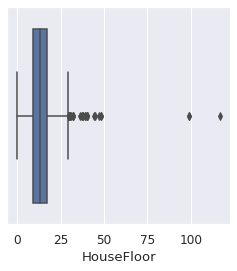

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_train['HouseFloor'], whis=1.5, orient='h')

In [ ]:
(df_train['HouseFloor'] == 0).sum()

269

In [ ]:
(df_train['HouseFloor'] > 75).sum()

3

У нас есть 269 значений, где нумерация этажности дома начинается с нуля. А также 3 значения высоты дома значительно отклоняется от среднего.

In [ ]:
df_train[df_train['HouseFloor'] > 75]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
1678,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
4657,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515


In [ ]:
# house_floor_mean = df_train['HouseFloor'].mean()
# house_floor_median = df_train['HouseFloor'].median()
# house_floor_mode = df_train['HouseFloor'].mode()[0]

In [ ]:
# print(f'Среднее значение HouseFloor = {house_floor_mean}')
# print(f'Медиана HouseFloor = {house_floor_median}')
# print(f'Мода HouseFloor = {house_floor_mode}')

In [ ]:
# df_train.loc[df_train['HouseYear'] == 1977, ['HouseFloor']].describe()

Отметим, что все здания с завышенным значением этажности были построены в 1977. Найдём моду по этажности домов за 1977 год без учёта выбросов. В принципе, она совпадает с самым часто встречающимся значением этажности за все года.

In [ ]:
query_house_floor = (df_train['HouseYear'] == 1977) & (df_train['HouseFloor'] < 75)
house_floor_mode_1977 = df_train.loc[query_house_floor, 'HouseFloor'].mode()[0]
house_floor_mode_1977

17.0

In [ ]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608


In [ ]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

Также у нас есть 1825 значений таких, что этаж, на котором расположена квартира, превышает количество этажей в доме.

Добавим новый столбец, в котором присвоим для наших выбросов значение 1. А для данных с неподозрительными значениями в новом столбце проставим 0.

In [ ]:
df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor_outlier'] = 1
df_train.loc[df_train['Floor'] > 75, 'HouseFloor_outlier'] = 1
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0


Заменим значение 0 этажа на 1.

In [ ]:
# df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = 1

In [ ]:
df_train.corr()['Price'][['Floor', 'HouseFloor']]

Floor         0.128715
HouseFloor    0.088494
Name: Price, dtype: float64

In [ ]:
df_train.loc[df_train['HouseFloor'] > 75, 'HouseFloor'] = house_floor_mode_1977

In [ ]:
df_train.corr()['Price'][['Floor', 'HouseFloor']]

Floor         0.128715
HouseFloor    0.089736
Name: Price, dtype: float64

Поменяем местами этажность дома и этаж на котором находится квартира. Это работает чуть лучше, чем просто поставить рандомный этаж от 1 до максмума.

In [ ]:
floors_index_outliers = df_train[df_train['HouseFloor'] < df_train['Floor']].index
df_train.loc[floors_index_outliers, 'Floor'], df_train.loc[floors_index_outliers, 'HouseFloor'] = df_train.loc[floors_index_outliers, 'HouseFloor'], df_train.loc[floors_index_outliers, 'Floor']

In [ ]:
df_train.corr()['Price'][['Floor', 'HouseFloor']]

Floor         0.110054
HouseFloor    0.115803
Name: Price, dtype: float64

In [ ]:
# df_train.loc[floors_index_outliers, 'Floor'] = df_train.loc[floors_index_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [ ]:
df_train.corr()['Price'][['Floor', 'HouseFloor']]

Floor         0.103166
HouseFloor    0.089736
Name: Price, dtype: float64

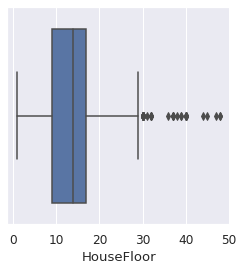

In [ ]:
plt.figure(figsize=(4, 4))
sns.boxplot(df_train['HouseFloor'], whis=1.5, orient='h')

## Обработка отстутсвующих значений.

Составим карту отсутствующих значений.

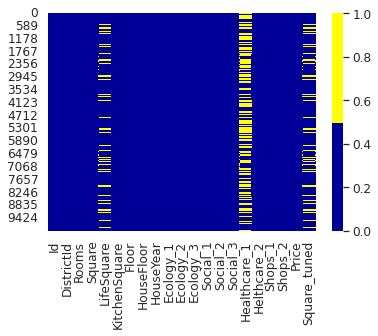

In [ ]:
# cols = df_train.columns[:30] # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df_train[df_train.columns].isnull(), cmap=sns.color_palette(colours))

Видно, что у нас есть отсутствующие значения в признаках LifeSquare и Healthcare_1. Найдём долю отсутсвующих значений в по признакам.

Стоит помнить, что в случае, если пропусков у признака слишком много (более 70%), такой признак удаляют. Проверим, насколько полны наши признаки: метод isnull() пройдется по каждой ячейке каждого столбца и определит, кто пуст, а кто нет, составив датафрейм такого же размера, состоящий из True / False. Метод mean() суммирует все значения True, определит концентрацию пропусков в каждом столбце. На 100 мы умножаем, чтобы получить значение в процентах:

In [ ]:
# df_train.isnull().mean() * 100
colums_with_na = ['LifeSquare', 'Healthcare_1']

# for col in df_train.columns:
#     # pct_missing = np.mean(df_train[col].isnull())
#     print('{} - {}%'.format(col, round(np.mean(df_train[col].isnull()) * 100, 2)))

for col in colums_with_na:
    # pct_missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(np.mean(df_train[col].isnull()) * 100, 2)))  

LifeSquare - 21.13%
Healthcare_1 - 47.98%


Можем вспомнить слабую корреляцию Healthcare_1 с остальными фичами и, учитывая большое количество пропусков данных в этой фиче, удалим этот столбец.

В данном случае у нас нет признаков с более 70 процентами пропусков, таких, что мы могли бы выбросить

https://www.helenkapatsa.ru/razvedochnyy-analiz-dannykh-chast-1/

In [ ]:
round(df_train.corr()['Healthcare_1'].sort_values(), 3)

HouseFloor      -0.144
Floor           -0.138
Ecology_1       -0.044
Square          -0.040
LifeSquare      -0.027
HouseYear       -0.012
KitchenSquare    0.009
Rooms            0.043
Social_2         0.050
Shops_1          0.058
Social_1         0.077
Social_3         0.134
Price            0.139
Helthcare_2      0.203
Healthcare_1     1.000
Name: Healthcare_1, dtype: float64

In [ ]:
df_train = df_train.drop(['Healthcare_1'], axis = 1)